In [35]:
import urllib.parse

import colorcet as cc  # noqa: F401
import geopandas as gpd
import geoviews as gv
import geoviews.tile_sources as gvts
import holoviews as hv
import pandas as pd
import panel as pn
from bokeh.models import HoverTool
from bokeh.models.widgets.tables import NumberFormatter

In [2]:
import datetime

import requests

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
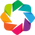

In [169]:
# gv.extension("bokeh")
hv.extension("bokeh")
pn.extension("tabulator")
pn.extension(design="material")

In [265]:
pn.extension(
    defer_load=True,
    loading_spinner="arc",
    loading_indicator=True,
    throttled=True,
    # loading_color="#0000ff",
)

In [131]:
nepal = gpd.read_parquet("data/nepal.parq").dissolve()
nepal = nepal.dissolve()

bounds = nepal.bounds
minx, miny, maxx, maxy = bounds.iloc[0].values

In [212]:
CATALOG_URL = "https://earthquake.usgs.gov/fdsnws/event/1/query.geojson"
params = dict(
    starttime="2010-10-07",
    endtime=str(datetime.date.today()),
    maxlatitude=maxy,
    minlatitude=miny,
    maxlongitude=maxx,
    minlongitude=minx,
    minmagnitude=3,
    eventtype="earthquake",
    orderby="time",
)
columns = ["mag", "place", "time", "geometry", "depth"]

url = f"{CATALOG_URL}?{urllib.parse.urlencode(params)}"
quakes = gpd.read_file(url, columns=columns)

In [213]:
nepal_buffer = nepal.to_crs(epsg=3857).buffer(20000).to_crs(epsg=4326)
quakes = quakes[quakes.within(nepal_buffer.loc[0])]

In [214]:
quakes["time"] = pd.to_datetime(quakes["time"], unit="ms").dt.tz_localize(
    tz="Asia/Kathmandu"
)
quakes = quakes.set_index("time").sort_index()

In [247]:
quakes["longitude"] = quakes["geometry"].x
quakes["latitude"] = quakes["geometry"].y
quakes = quakes.drop(columns="geometry")

In [248]:
slider_stylesheet = """
:host {
    top: -75px !important;
    width: 300px;
    left: 20px;
}
"""

last_date = quakes.index.max().date()
earliest_date = quakes.index.min().date()
date_slider = pn.widgets.DateRangeSlider(
    name="Date Range",
    start=earliest_date,
    end=last_date,
    value=(earliest_date, last_date),
    sizing_mode="stretch_width",
    stylesheets=[slider_stylesheet],
)

info = pn.pane.Alert(
    f"**{len(quakes)}** earthquakes recorded between {earliest_date:%F} and {last_date:%F}"
)

mag_range = (quakes["mag"].min(), quakes["mag"].max())

In [249]:
table_stylesheet = """
:host {
    flex: 1 0 30%;
}
.tabulator-cell {
    font-size: 14px;
}
"""

quake_table = pn.widgets.Tabulator(
    quakes[["mag", "latitude", "longitude"]],
    show_index=True,
    page_size=10,
    selectable=False,
    sortable={
        "mag": True,
        "longitude": False,
        "latitude": False,
    },
    formatters={
        "mag": NumberFormatter(format="0.0"),
        "longitude": NumberFormatter(format="0.00"),
        "latitude": NumberFormatter(format="0.00"),
    },
    editors={"mag": None, "longitude": None, "latitude": None},
    titles={
        "time": "Date/Time",
        "mag": "Mag.",
        "longitude": "Long",
        "latitude": "Lat",
    },
    theme="bulma",
    layout="fit_data",
    stylesheets=[table_stylesheet],
)

In [262]:
def plot_quakes(date_range):
    dates = [pd.Timestamp(x, tz="UTC") for x in date_range]
    data = quakes.loc[dates[0] : dates[1]]
    quake_table.value = data[["mag", "latitude", "longitude"]]

    hover_tool = HoverTool(
        tooltips=[
            ("Date", "@time{%d %b %Y %I:%M %p}"),
            ("Magnitude: ", "@mag{0.0}"),
            ("Place", "@place"),
        ],
        formatters={"@time": "datetime"},
    )

    data = data.reset_index()
    # use 'time_color' for the colorbar, since the colors need to be a float or int
    data["time_color"] = data.index.to_series()
    cbar_opts = dict(
        major_label_overrides=data["time"].dt.strftime("%Y-%m-%d").to_dict(),
        major_label_text_align="left",
    )

    return gv.Points(
        data,
        kdims=["longitude", "latitude"],
        vdims=["mag", "time", "time_color", "place"],
    ).opts(
        tools=[hover_tool],
        size=(2 ** gv.dim("mag")) / 4,
        cmap="viridis",
        color="time_color",
        fill_alpha=0.5,
        colorbar=True,
        colorbar_opts=cbar_opts,
        toolbar="above",
    )


quake_points = pn.bind(plot_quakes, date_range=date_slider)
points = hv.DynamicMap(quake_points)

In [263]:
nepal_map = gv.Path(nepal).opts(color="black")

plot = nepal_map.opts(
    # alpha=0.1,
    xaxis=None,
    yaxis=None,
    active_tools=["pan", "wheel_zoom"],
    default_tools=["pan", "wheel_zoom"],
    data_aspect=1,
    responsive="width",
) * points.opts(
    data_aspect=1,
    responsive="width",
).redim.range(mag=mag_range)
map_css = """
:host {
    flex: 2 1 65%;
}
"""
plot_layout = pn.layout.Column(plot, date_slider, stylesheets=[map_css])

In [260]:
flex_css = """
@media screen and (max-width: 1200px) {
  div[id^="flexbox"] {
    flex-flow: column !important;
  }
}
"""
layout = pn.layout.FlexBox(plot_layout, quake_table, stylesheets=[flex_css])

In [254]:
template = pn.template.MaterialTemplate(
    site="", title="Earthquakes in Nepal", sidebar=[], main=[layout]
)
template.servable()

MaterialTemplate
    [js_area] HTML(None, design=<class 'panel.theme.materi..., height=0, margin=0, sizing_mode='fixed', width=0)
    [actions] MaterialTemplateActions()
    [browser_info] BrowserInfo(dark_mode=True, device_pixel_ratio=1, language='en-GB', timezone='Australia/Brisbane', timezone_offset=-600, webdriver=False, webgl=True)
    [busy_indicator] LoadingSpinner(height=20, width=20)
    [main-140314377042832] FlexBox(design=<class 'panel.theme.materi..., objects=[Column(design=<class 'pan...], sizing_mode='stretch_width', stylesheets=['\n@media screen a...])